In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

DATA TRANSFORMATION

In [2]:
df_training_set = pd.read_csv("Fashion/train.csv")
df_testing_set = pd.read_csv("Fashion/test.csv")

In [3]:
df_training_set.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df_testing_set.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
y_train = np.array(df_training_set['label'])
y_train

array([2, 9, 6, ..., 8, 8, 7])

In [6]:
X_train = np.array(df_training_set.loc[:,'pixel1' : 'pixel784']) / 255
X_test = np.array(df_testing_set.loc[:, 'pixel1' : 'pixel784']) / 255

Label: 0


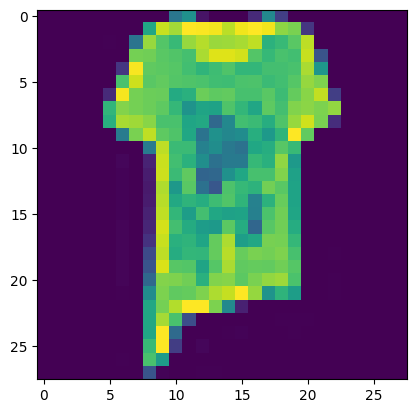

In [7]:
def view_image(index):
    global X_train, y_train
    image = (X_train * 255)[index]
    label = (y_train)[index]
    print("Label:", label)
    image = image.reshape(28, 28)
    plt.imshow(image)
    plt.show

view_image(5000)

NEURAL NETWORK FRAMEWORK

In [8]:
class Layer_Dense():
    def __init__(self, n_inputs, n_neurons):
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases

    def back(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis = 0, keepdims=True)

        self.dinputs = np.dot(dvalues, self.weights.T)

In [9]:
class Activation_ReLU():
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)

    def back(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0

In [10]:
class Activation_Softmax():
    def forward(self, inputs):
        exp_values = np.exp(inputs - np.max(inputs, axis = 1, keepdims=True))
        probabilities = exp_values / np.sum(exp_values, axis = 1, keepdims=True)
        self.output = probabilities

In [11]:
class Loss_CategoricalCrossEntropy():
    def forward(self, y_pred, y_true):
        samples = len(y_pred)
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        correct_confidences = y_pred_clipped[range(samples), y_true]

        negative_log_likelihood = -np.log(correct_confidences)
        return negative_log_likelihood
    
    def calculate(self, output, y):
        sample_losses = self.forward(output, y)
        data_loss = np.mean(sample_losses)
        return data_loss

In [12]:
class Activation_SM_Loss_CCE():
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossEntropy()

    def forward(self, inputs, y_true):
        self.activation.forward(inputs)
        self.output = self.activation.output

        return self.loss.calculate(self.output, y_true)
    
    def back(self, dvalues, y_true):
        samples = len(dvalues)
        self.dinputs = dvalues.copy()

        self.dinputs[range(samples), y_true] -= 1

        self.dinputs = self.dinputs / samples

In [13]:
class Optimizer_SGD():
    def __init__(self, learningrate = 1):
        self.learning_rate = learningrate
    
    def update(self, layer):
        layer.weights += -self.learning_rate * layer.dweights
        layer.biases += -self.learning_rate * layer.dbiases

MODEL CREATION

In [14]:
dense1 = Layer_Dense(784, 25)
activation1 = Activation_ReLU()

dense2 = Layer_Dense(25, 10)
loss_activation = Activation_SM_Loss_CCE()

In [15]:
optimizer = Optimizer_SGD(0.1)

TRAINING


In [16]:
def train(epochs):
    global X_train, y_train

    for epoch in range(epochs):
        dense1.forward(X_train)
        activation1.forward(dense1.output)

        dense2.forward(activation1.output)
        loss = loss_activation.forward(dense2.output, y_train)

        predictions = np.argmax(loss_activation.output, axis=1)
        accuracy = np.mean(predictions == y_train)

        if epoch % 10 == 0:
            print(f"Epoch: {epoch}, Loss: {loss:.4f}, Accuracy: {accuracy * 100:.4f}%")

        loss_activation.back(loss_activation.output, y_train)
        dense2.back(loss_activation.dinputs)

        activation1.back(dense2.dinputs)
        dense1.back(activation1.dinputs)

        optimizer.update(dense1)
        optimizer.update(dense2)

    return accuracy, loss

In [17]:
acc1, loss1 = train(251)

Epoch: 0, Loss: 2.3026, Accuracy: 9.2233%
Epoch: 10, Loss: 2.2917, Accuracy: 23.4250%
Epoch: 20, Loss: 2.2449, Accuracy: 20.6617%
Epoch: 30, Loss: 2.0827, Accuracy: 21.4067%
Epoch: 40, Loss: 1.7898, Accuracy: 37.4000%
Epoch: 50, Loss: 1.5429, Accuracy: 49.8450%
Epoch: 60, Loss: 1.3744, Accuracy: 54.8083%
Epoch: 70, Loss: 1.2516, Accuracy: 57.2350%
Epoch: 80, Loss: 1.1548, Accuracy: 59.1883%
Epoch: 90, Loss: 1.0769, Accuracy: 61.0900%
Epoch: 100, Loss: 1.0141, Accuracy: 63.1517%
Epoch: 110, Loss: 0.9628, Accuracy: 64.8017%
Epoch: 120, Loss: 0.9206, Accuracy: 66.1317%
Epoch: 130, Loss: 0.8858, Accuracy: 66.9433%
Epoch: 140, Loss: 0.9409, Accuracy: 64.2783%
Epoch: 150, Loss: 0.8997, Accuracy: 64.9867%
Epoch: 160, Loss: 0.8702, Accuracy: 65.7567%
Epoch: 170, Loss: 0.8474, Accuracy: 66.4383%
Epoch: 180, Loss: 0.8283, Accuracy: 67.1483%
Epoch: 190, Loss: 0.8116, Accuracy: 67.9217%
Epoch: 200, Loss: 0.7967, Accuracy: 68.6667%
Epoch: 210, Loss: 0.7831, Accuracy: 69.3850%
Epoch: 220, Loss: 0.77

In [18]:
acc2, loss2 = train(251)

Epoch: 0, Loss: 0.7323, Accuracy: 73.2850%
Epoch: 10, Loss: 0.7229, Accuracy: 73.7533%
Epoch: 20, Loss: 0.7139, Accuracy: 74.1733%
Epoch: 30, Loss: 0.7053, Accuracy: 74.5867%
Epoch: 40, Loss: 0.6971, Accuracy: 74.9500%
Epoch: 50, Loss: 0.6893, Accuracy: 75.2550%
Epoch: 60, Loss: 0.6817, Accuracy: 75.5650%
Epoch: 70, Loss: 0.6743, Accuracy: 75.8717%
Epoch: 80, Loss: 0.6673, Accuracy: 76.1567%
Epoch: 90, Loss: 0.6605, Accuracy: 76.4883%
Epoch: 100, Loss: 0.6540, Accuracy: 76.8083%
Epoch: 110, Loss: 0.6477, Accuracy: 77.0667%
Epoch: 120, Loss: 0.6416, Accuracy: 77.2867%
Epoch: 130, Loss: 0.6357, Accuracy: 77.5133%
Epoch: 140, Loss: 0.6300, Accuracy: 77.7417%
Epoch: 150, Loss: 0.6245, Accuracy: 77.9600%
Epoch: 160, Loss: 0.6191, Accuracy: 78.1617%
Epoch: 170, Loss: 0.6140, Accuracy: 78.3933%
Epoch: 180, Loss: 0.6090, Accuracy: 78.5950%
Epoch: 190, Loss: 0.6041, Accuracy: 78.7967%
Epoch: 200, Loss: 0.5994, Accuracy: 78.9567%
Epoch: 210, Loss: 0.5948, Accuracy: 79.1233%
Epoch: 220, Loss: 0.5

In [19]:
acc3, loss3 = train(251)

Epoch: 0, Loss: 0.5776, Accuracy: 79.4900%
Epoch: 10, Loss: 0.5735, Accuracy: 79.6933%
Epoch: 20, Loss: 0.5693, Accuracy: 79.9283%
Epoch: 30, Loss: 0.5654, Accuracy: 80.1233%
Epoch: 40, Loss: 0.5622, Accuracy: 80.2467%
Epoch: 50, Loss: 0.5598, Accuracy: 80.3933%
Epoch: 60, Loss: 0.5573, Accuracy: 80.5150%
Epoch: 70, Loss: 0.5546, Accuracy: 80.6100%
Epoch: 80, Loss: 0.5520, Accuracy: 80.6683%
Epoch: 90, Loss: 0.5496, Accuracy: 80.7067%
Epoch: 100, Loss: 0.5472, Accuracy: 80.8267%
Epoch: 110, Loss: 0.5450, Accuracy: 80.8833%
Epoch: 120, Loss: 0.5429, Accuracy: 80.9500%
Epoch: 130, Loss: 0.5411, Accuracy: 80.9500%
Epoch: 140, Loss: 0.5394, Accuracy: 80.9650%
Epoch: 150, Loss: 0.5379, Accuracy: 81.0250%
Epoch: 160, Loss: 0.5397, Accuracy: 81.1067%
Epoch: 170, Loss: 0.5455, Accuracy: 80.9083%
Epoch: 180, Loss: 0.5356, Accuracy: 81.1550%
Epoch: 190, Loss: 0.5267, Accuracy: 81.4400%
Epoch: 200, Loss: 0.5219, Accuracy: 81.5433%
Epoch: 210, Loss: 0.5189, Accuracy: 81.6833%
Epoch: 220, Loss: 0.5

In [20]:
acc4, loss4 = train(151)

Epoch: 0, Loss: 0.5147, Accuracy: 82.0567%
Epoch: 10, Loss: 0.5130, Accuracy: 82.1017%
Epoch: 20, Loss: 0.5114, Accuracy: 82.1600%
Epoch: 30, Loss: 0.5098, Accuracy: 82.2183%
Epoch: 40, Loss: 0.5082, Accuracy: 82.2967%
Epoch: 50, Loss: 0.5066, Accuracy: 82.3400%
Epoch: 60, Loss: 0.5051, Accuracy: 82.4233%
Epoch: 70, Loss: 0.5036, Accuracy: 82.4833%
Epoch: 80, Loss: 0.5021, Accuracy: 82.5483%
Epoch: 90, Loss: 0.5007, Accuracy: 82.6100%
Epoch: 100, Loss: 0.4992, Accuracy: 82.6717%
Epoch: 110, Loss: 0.4978, Accuracy: 82.7117%
Epoch: 120, Loss: 0.4964, Accuracy: 82.7783%
Epoch: 130, Loss: 0.4951, Accuracy: 82.8317%
Epoch: 140, Loss: 0.4941, Accuracy: 82.8483%
Epoch: 150, Loss: 0.4940, Accuracy: 82.7617%


In [21]:
acc5, loss5 = train(151)

Epoch: 0, Loss: 0.4887, Accuracy: 82.7350%
Epoch: 10, Loss: 0.4908, Accuracy: 82.5783%
Epoch: 20, Loss: 0.5010, Accuracy: 81.9417%
Epoch: 30, Loss: 0.5029, Accuracy: 81.8583%
Epoch: 40, Loss: 0.4933, Accuracy: 82.4950%
Epoch: 50, Loss: 0.4860, Accuracy: 82.9150%
Epoch: 60, Loss: 0.4826, Accuracy: 83.1100%
Epoch: 70, Loss: 0.4862, Accuracy: 83.0383%
Epoch: 80, Loss: 0.4946, Accuracy: 82.8467%
Epoch: 90, Loss: 0.4894, Accuracy: 83.0433%
Epoch: 100, Loss: 0.4853, Accuracy: 83.1350%
Epoch: 110, Loss: 0.4833, Accuracy: 83.1983%
Epoch: 120, Loss: 0.4820, Accuracy: 83.2467%
Epoch: 130, Loss: 0.4810, Accuracy: 83.2650%
Epoch: 140, Loss: 0.4799, Accuracy: 83.2933%
Epoch: 150, Loss: 0.4788, Accuracy: 83.3483%


In [22]:
print(acc5)
print(loss5)

0.8334833333333334
0.47878087776520845


TESTING

In [23]:
activation2 = Activation_Softmax()

In [35]:
def test(index):
    global X_test

    dense1.forward(X_test)
    activation1.forward(dense1.output)

    dense2.forward(activation1.output)
    activation2.forward(dense2.output)

    prediction = np.argmax(activation2.output[index])

    print("Prediction:", prediction)
    
    image = (X_test * 255)[index]
    image = image.reshape(28,28)

    plt.imshow(image)
    plt.show
    

Prediction: 0


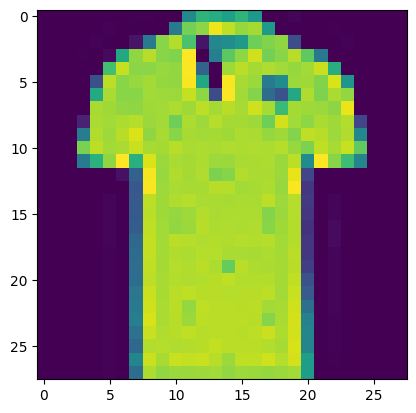

In [36]:
test(200)

Prediction: 4


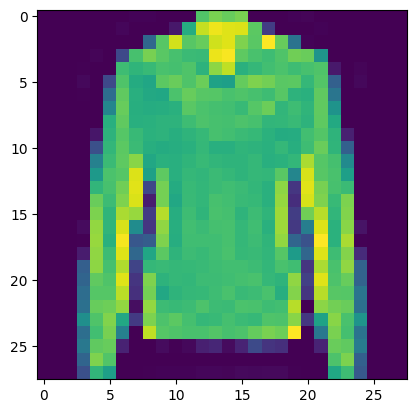

In [38]:
test(150)

Prediction: 0


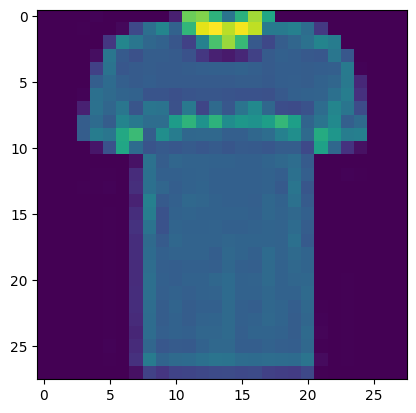

In [39]:
test(420)

Prediction: 1


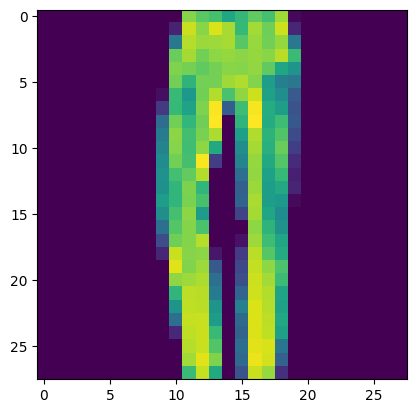

In [40]:
test(1)

Prediction: 8


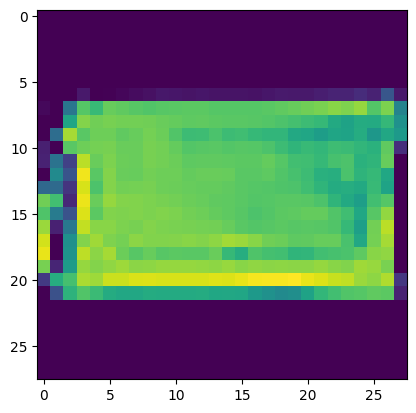

In [41]:
test(5879)

Prediction: 2


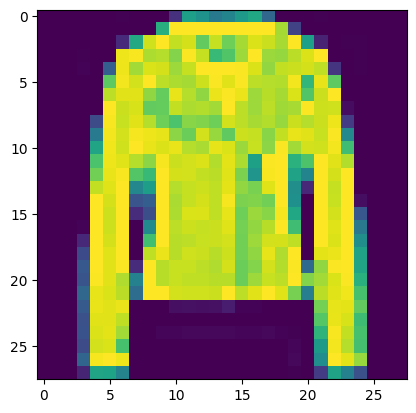

In [42]:
test(1911)

Prediction: 7


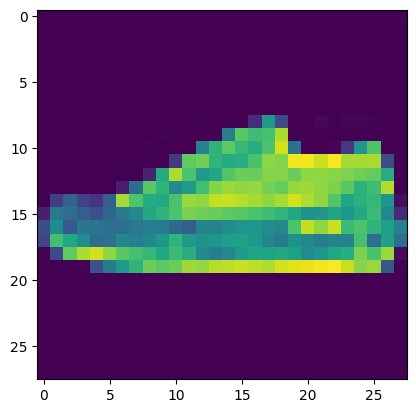

In [43]:
test(98)